In [108]:
from __future__ import division
import matplotlib
from pylab import *
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import linregress
from scipy.signal import argrelextrema
import numpy as np
import pandas as pd
import math
from ddeint import ddeint
import copy

In [109]:
# Define some plotting styles that we will use.
fontSize=15
matplotlib.rcParams.update({"axes.formatter.limits": (-4,4),'font.family':'Avenir','font.size': fontSize, "axes.titlesize": fontSize, "xtick.labelsize": fontSize, "ytick.labelsize": fontSize,})
plotStyles={"markersize":12,"markeredgewidth":2.0,"linewidth":2.0}
stepStyles={"markersize":15,"markeredgewidth":3.0,"linewidth":4.0,"where":"post"}
scatterStyles={"linewidth":1.0}

In [110]:
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go

pio.templates.default = "simple_white"

# 1 Lambda ts
## 1.1 Load data

In [111]:
df=pd.read_csv('../data/TECAN_240128.csv',delimiter=',',index_col=0)  
#time = df.to_numpy()[0]/60

In [112]:
def f_constant(x,c):
    return c

xdata = df.to_numpy()[0]/60;
ydata = df.to_numpy()[1];
param, cov = curve_fit(f_constant, xdata[1:], ydata[1:])
av_T = str(param[0])[:5]

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=xdata,
    y=ydata,
    mode='lines+markers', # Style name/legend entry with html tags
    name='Raw'# override default to connect the gaps
))

fig.add_trace(go.Scatter(
    x=xdata,
    y=np.repeat(param[0],len(xdata)),
    name='Fit',
))

fig.add_annotation(x=370, y=38.8,
            text='average T = '+av_T+' C')

fig.update_layout(xaxis_title='Time (min)',\
                  yaxis_title='Temperature (C)',\
                  updatemenus=[dict(\
                       buttons=[\
                                dict(label="Linear",  method="relayout", args=[{"yaxis.type": "linear"}]),\
                                dict(label="Log", method="relayout", args=[{"yaxis.type": "log"}]),\
                               ])])
fig.update_xaxes(showgrid=True)
fig.update_yaxes(showgrid=True)
fig.update_yaxes(range=[37.5, 39])
fig.layout.font.family = 'Arial'; fig.layout.font.size = 16

fig.show()
#fig.write_html("../data_240128/01_temperature.html")

In [113]:
ydata1 = df.loc['F7'].to_numpy()
ydata2 = df.loc['F8'].to_numpy()

ymean = (ydata1+ydata2)/2; 
ymean_0125 = ymean;

In [114]:
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=xdata,
    y=ydata1,
    mode='lines+markers', # Style name/legend entry with html tags
    name='F7:LBM'# override default to connect the gaps
))

fig.add_trace(go.Scatter(
    x=xdata,
    y=ydata2,
    mode='lines+markers', # Style name/legend entry with html tags
    name='F8:LBM'# override default to connect the gaps
))

fig.add_trace(go.Scatter(
    x=xdata,
    y=ymean,
    mode='lines+markers', # Style name/legend entry with html tags
    line=dict(color='black'),
    name='mean'# override default to connect the gaps
))

fig.update_layout(template='simple_white',\
                  xaxis_title='Time (min)',\
                  yaxis_title='OD600 (blank)',\
                  updatemenus=[dict(\
                       buttons=[\
                                dict(label="Linear",  method="relayout", args=[{"yaxis.type": "linear"}]),\
                                dict(label="Log", method="relayout", args=[{"yaxis.type": "log"}]),\
                               ])])


#fig.add_vrect(x0=100, x1=xdata[-1], line_width=0, fillcolor="black", opacity=0.05)

#fig.add_annotation(x=470, y=0.0885,
#            text='average blank OD = '+str(ymean)[:6])

fig.update_xaxes(showgrid=True)
fig.update_yaxes(showgrid=True)
fig.layout.font.family = 'Arial'; fig.layout.font.size = 16

fig.show()
#fig.write_html("../data_240128/02_blank_ts.html")


In [115]:
ymean_LB = ymean;

In [116]:
from matplotlib.pyplot import cm
colors=cm.rainbow(np.linspace(0,1,10))
colors

array([[5.00000000e-01, 0.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [2.80392157e-01, 3.38158275e-01, 9.85162233e-01, 1.00000000e+00],
       [6.07843137e-02, 6.36474236e-01, 9.41089253e-01, 1.00000000e+00],
       [1.66666667e-01, 8.66025404e-01, 8.66025404e-01, 1.00000000e+00],
       [3.86274510e-01, 9.84086337e-01, 7.67362681e-01, 1.00000000e+00],
       [6.13725490e-01, 9.84086337e-01, 6.41213315e-01, 1.00000000e+00],
       [8.33333333e-01, 8.66025404e-01, 5.00000000e-01, 1.00000000e+00],
       [1.00000000e+00, 6.36474236e-01, 3.38158275e-01, 1.00000000e+00],
       [1.00000000e+00, 3.38158275e-01, 1.71625679e-01, 1.00000000e+00],
       [1.00000000e+00, 1.22464680e-16, 6.12323400e-17, 1.00000000e+00]])

In [117]:
def rgb_to_hex(rgb):
    return '%02x%02x%02x' % rgb

colors_hex = [];
for k in range(len(colors)):
    rgb1 = int(colors[k,0]*255);
    rgb2 = int(colors[k,1]*255);
    rgb3 = int(colors[k,2]*255);
    colors_hex.append('#'+rgb_to_hex((rgb1, rgb2, rgb3)))

In [118]:
my_dict = {'no dilu':['A1','A2'],
          '1e1 dilu':['A3','A4'],
          '1e2 dilu':['A5','A6'],
          '1e3 dilu':['A7','A8'],
          '1e4 dilu':['B1','B2'],
          '1e5 dilu':['B3','B4'],
          '1e6 dilu':['B5','B6'],
          '1e7 dilu':['B7','B8']}
labels = list(my_dict.keys())

In [119]:
xdata = df.to_numpy()[0]/60;

labels = list(my_dict.keys())

fig = go.Figure()
k = 0;
for label_ in labels:
    for j in my_dict[label_]:
        fig.add_trace(go.Scatter(
        x=xdata,
        y=df.loc[j].to_numpy()-ymean,
        mode='lines', # Style name/legend entry with html tags
        name=label_+':'+j,
        line=dict(color=colors_hex[k]),# override default to connect the gaps
        ))
    k =k+1;

for spl in ['C1','C2']:
    fig.add_trace(go.Scatter(
            x=xdata,
            y=df.loc[spl].to_numpy()-ymean,
            mode='markers', # Style name/legend entry with html tags
            name='splA:'+spl,
            marker_color='rgba(192, 192, 192, 0.5)',
            marker_symbol='circle',
        ))    
    
for spl in ['C3','C4']:
    fig.add_trace(go.Scatter(
            x=xdata,
            y=df.loc[spl].to_numpy()-ymean,
            mode='markers', # Style name/legend entry with html tags
            name='splB:'+spl,
            marker_color='rgba(192, 192, 192, 0.5)',
            marker_symbol='x',
        ))    
    
for spl in ['C5','C6']:
    fig.add_trace(go.Scatter(
            x=xdata,
            y=df.loc[spl].to_numpy()-ymean,
            mode='markers', # Style name/legend entry with html tags
            name='splC:'+spl,
            marker_color='rgba(192, 192, 192, 0.5)',
            marker_symbol='square',
        ))   
    
for uninf in ['C7','C8']:
    fig.add_trace(go.Scatter(
            x=xdata,
            y=df.loc[uninf].to_numpy()-ymean,
            mode='lines', # Style name/legend entry with html tags
            name='uninf:'+uninf,
            line=dict(color='black',dash='dash'),# override default to connect the gaps
        ))

fig.add_vline(x=xdata[6], line_width=3, line_dash="dash", line_color="red")    

fig.update_layout(xaxis_title='Time (min)',\
                  yaxis_title='TECAN OD600 (blank subtracted)',\
                  updatemenus=[dict(\
                       buttons=[\
                                dict(label="Linear",  method="relayout", args=[{"yaxis.type": "linear"}]),\
                                dict(label="Log", method="relayout", args=[{"yaxis.type": "log"}]),\
                               ])])
fig.update_xaxes(showgrid=True)
fig.update_yaxes(showgrid=True)
#fig.update_layout(title_text='1:500 dilution from overnight', title_x=0.5)
fig.layout.font.family = 'Arial'; fig.layout.font.size = 14

fig.show()
#fig.write_html("../data_240128/03_OD_nonblank_ts.html")

## 1.2 Identify massive lysis

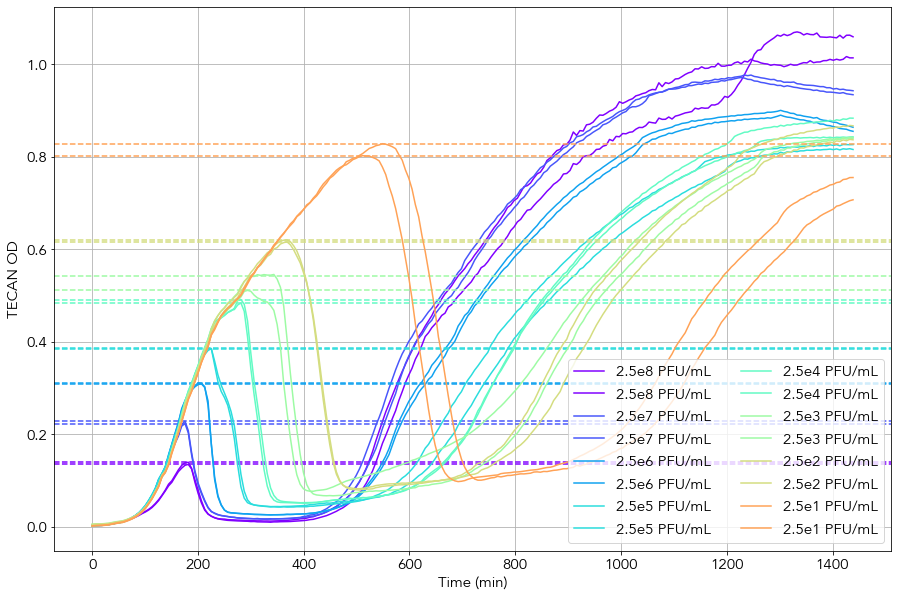

In [120]:
OD_01 = {};
time_01= {}; 
idx_01 = {};

k = 0; 
i = 8; 

# Define some plotting styles that we will use.
fontSize=15
matplotlib.rcParams.update({"axes.formatter.limits": (-4,4),'font.family':'Avenir','font.size': fontSize, "axes.titlesize": fontSize, "xtick.labelsize": fontSize, "ytick.labelsize": fontSize,})
plotStyles={"markersize":12,"markeredgewidth":2.0,"linewidth":2.0}
stepStyles={"markersize":15,"markeredgewidth":3.0,"linewidth":4.0,"where":"post"}
scatterStyles={"linewidth":1.0}
matplotlib.rcParams.update({"figure.figsize": (15,10)})
for label_ in labels:
    OD = np.array([]);
    time_ = np.array([]);
    indx_ = np.array([]); 
    for j in my_dict[label_]:
        x_ = df.to_numpy()[0]/60
        y_ = df.loc[j].to_numpy() - ymean
        if i < 10:
            y_tmp = y_[x_>150]; 
            idx = argrelextrema(y_tmp, np.greater_equal)[0][0];
            if i <= 1:
                y_tmp2 = y_[(x_>250)&(x_<1200)]; 
                y_tmp = y_[x_>250]; 
                idx = argmax(y_tmp2);
        else:
            y_tmp = y_[x_>80]; 
            idx = argrelextrema(y_tmp, np.greater_equal)[0][0];
        idx = idx + len(y_) - len(y_tmp);
        plt.plot(x_, y_, color = colors[k,:], label='2.5e'+str(i)+' PFU/mL')
        plt.axhline(y_[idx], color = colors[k,:], linestyle = '--')
        OD = np.append(OD, y_[idx]);
        time_ = np.append(time_, x_[idx]);
        indx_ = np.append(indx_, idx);
    OD_01[i] = OD; 
    time_01[i] = time_;
    idx_01[i] = indx_; 
    k = k+1; 
    i = i-1;
#plt.title('1:500 dilution from overnight')
plt.xlabel('Time (min)')
plt.ylabel('TECAN OD')
#plt.yscale('log')
plt.grid(True)
plt.legend(ncol=2,loc='lower right')

In [121]:
def get_lysisOD(df, idj, ymean, t_thesh):
    x_ = df.to_numpy()[0]/60
    y_ = df.loc[idj].to_numpy() - ymean;
    
    y_tmp = y_[x_>t_thesh]; 
    idx = argrelextrema(y_tmp, np.greater_equal)[0][0];
    
    idx = idx + len(y_) - len(y_tmp);
    lysisOD = y_[idx]; 
    return lysisOD

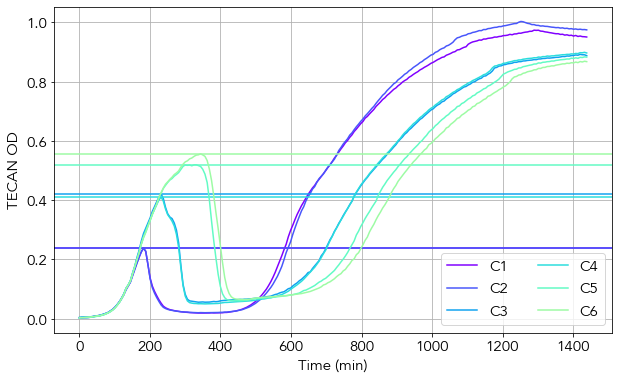

In [122]:
matplotlib.rcParams.update({"figure.figsize": (10,6)})

t_thesh = 150; 


n = 0; 

lysisODlist = {}; 
for idj in ['C1','C2','C3','C4','C5','C6']:
    lysisODlist[idj] = get_lysisOD(df, idj, ymean_LB, t_thesh); 
    x_ = df.to_numpy()[0]/60
    y_ = df.loc[idj].to_numpy() - ymean;
    plt.plot(x_,y_,color=colors[n],label=idj)
    plt.axhline(y=lysisODlist[idj],color=colors[n])
    n = n+1;
    
plt.xlabel('Time (min)')
plt.ylabel('TECAN OD')
#plt.yscale('log')
plt.grid(True)
plt.legend(ncol=2,loc='lower right')


## 1.3 Linear calibration 

Text(0.5, 1.0, 'Calibration curve for $\\lambda_{ts}$ at 38 C')

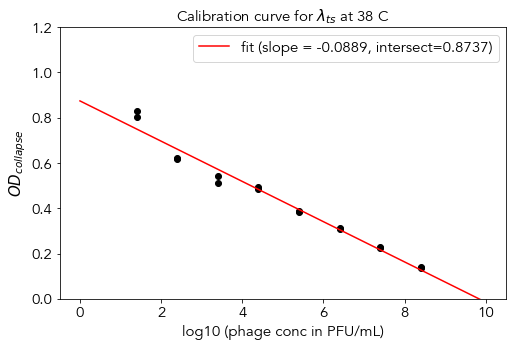

In [123]:
def linear(x,k,b):
    return k*x + b

# Define some plotting styles that we will use.
fontSize=15
matplotlib.rcParams.update({"axes.formatter.limits": (-4,4),'font.family':'Avenir','font.size': fontSize, "axes.titlesize": fontSize, "xtick.labelsize": fontSize, "ytick.labelsize": fontSize,})
plotStyles={"markersize":12,"markeredgewidth":2.0,"linewidth":2.0}
stepStyles={"markersize":15,"markeredgewidth":3.0,"linewidth":4.0,"where":"post"}
scatterStyles={"linewidth":1.0}
matplotlib.rcParams.update({"figure.figsize": (8,5)})
x_data = np.array([]);
y_data = np.array([]); 
for i in np.arange(8,0,-1):
    phage = 2.5*10**i; 
    for j in OD_01[i]:
        if i == 9 and j > 0.3:
            next;
        else:
            if i < 1:
                plt.plot(np.log10(phage), j, 'o', color='lightgray')
            else:
                plt.plot(np.log10(phage), j, 'o', color='k')
                x_data = np.append(x_data, np.log10(phage))
                y_data = np.append(y_data, j)
popt, pcov = curve_fit(linear, x_data[::], y_data[::])
xdata = np.linspace(0, 10, 1000); 
plt.plot(xdata, linear(xdata, *popt),color='r', label='fit (slope = '+'{:.4f}'.format(popt[0])+\
         ', intersect='+'{:.4f}'.format(popt[1])+')')
plt.legend()
plt.xlabel('log10 (phage conc in PFU/mL)')
plt.ylabel('$OD_{collapse}$')
plt.ylim((0,1.2))
#plt.grid(True)
plt.title('Calibration curve for $\lambda_{ts}$ at 38 C')

In [124]:
x_datats = x_data;
y_datats = y_data; 

In [125]:
def error_bar_of_calibration_curve(xdat,ydat,n_sample):
    size = len(xdat); 
    idx_arr = np.arange(0,size,1);
    k_arr = np.zeros(n_sample);
    b_arr = np.zeros(n_sample);
    for N in range(n_sample):
        idx_new = np.random.choice(idx_arr,size);
    
        x_new = xdat[idx_new];
        y_new = ydat[idx_new];
        
        
    
        popt_new, pcov_new = curve_fit(linear, x_new, y_new);
        k_arr[N] = popt_new[0];
        b_arr[N] = popt_new[1];
    return (k_arr, b_arr)

In [126]:
n_sample = 1000; 
(k_arr, b_arr) = error_bar_of_calibration_curve(x_datats,y_datats,n_sample);

In [127]:
def get_range_of_low_and_high(k_arr,b_arr):
    sizeA = 1000; 
    sizeB = len(k_arr);
    x__ = np.linspace(0,10,sizeA);
    y__ = np.zeros((sizeB,sizeA));
    for i in range(sizeB):
        y__[i,:] = linear(x__, k_arr[i], b_arr[i]);
    y__min = np.min(y__,axis=0)
    y__max = np.max(y__,axis=0)
    #print(len(y__min))
    return (y__min, y__max)

Text(0.5, 1.0, 'Calibration curve for $\\lambda_{ts}$ at 38 C')

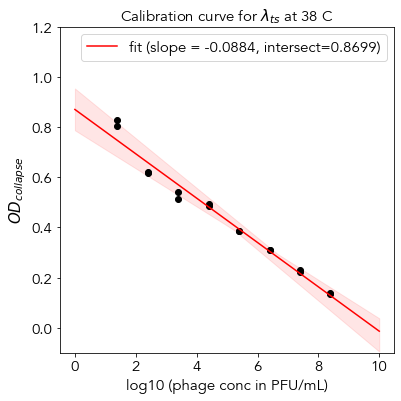

In [128]:
(y__min, y__max) = get_range_of_low_and_high(k_arr,b_arr);

k_arr_mean = np.mean(k_arr);
b_arr_mean = np.mean(b_arr);

########################plot########################
matplotlib.rcParams.update({"figure.figsize": (6,6)})

xdata = np.linspace(0, 10, 1000); 
plt.plot(x_datats, y_datats, 'o', color='k')
plt.plot(xdata, linear(xdata, k_arr_mean, b_arr_mean),color='r', \
         label='fit (slope = '+'{:.4f}'.format(k_arr_mean)+\
         ', intersect='+'{:.4f}'.format(b_arr_mean)+')')

plt.fill_between(xdata, y__min, y__max,color='r',alpha=0.1)
plt.xlabel('log10 (phage conc in PFU/mL)')
plt.ylabel('$OD_{collapse}$')
plt.ylim((-0.1,1.2))
plt.legend()
#plt.grid(True)
plt.title('Calibration curve for $\lambda_{ts}$ at 38 C')

In [129]:
#poptts = popt;
ymean_LB = ymean; 

Text(0.5, 1.0, 'Calibration curve for $\\lambda_{ts}$ at 38 C')

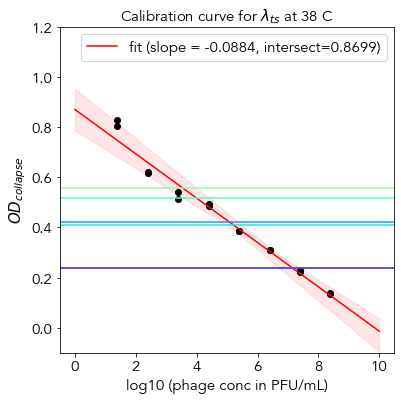

In [130]:
def linear(x,k,b):
    return k*x + b

matplotlib.rcParams.update({"figure.figsize": (6,6)})

xdata = np.linspace(0, 10, 1000); 
plt.plot(x_datats, y_datats, 'o', color='k')
plt.plot(xdata, linear(xdata, k_arr_mean, b_arr_mean),color='r', \
         label='fit (slope = '+'{:.4f}'.format(k_arr_mean)+\
         ', intersect='+'{:.4f}'.format(b_arr_mean)+')')

plt.fill_between(xdata, y__min, y__max,color='r',alpha=0.1)

n = 0; 
t_thesh = 150; 
for idj in ['C1','C2','C3','C4','C5','C6']:
    lysisOD = get_lysisOD(df, idj, ymean_LB, t_thesh); 
    plt.axhline(y=lysisOD,color=colors[n])
    n = n+1;
    
    
plt.xlabel('log10 (phage conc in PFU/mL)')
plt.ylabel('$OD_{collapse}$')
plt.ylim((-0.1,1.2))
plt.legend()
#plt.grid(True)
plt.title('Calibration curve for $\lambda_{ts}$ at 38 C')


In [131]:
def get_unknown_sample(CCpopt,lysisOD):
    log10_conc_in_well = (lysisOD-CCpopt[1])/CCpopt[0]
    log10_conc_in_tube = log10_conc_in_well + np.log10(51)
    return log10_conc_in_tube

In [132]:
matplotlib.rcParams.update({"figure.figsize": (15,10)})

t_thesh = 150; 


sample_conc = np.zeros(6)
sample_conc_err = np.zeros(6)
jj = 0; 
for idj in ['C1','C2','C3','C4','C5','C6']:
    lysisOD = get_lysisOD(df, idj, ymean_LB, t_thesh); 
    log10_conc_tmp = np.zeros(len(k_arr));
    for ii in range(len(k_arr)):
        popt_tmp = [k_arr[ii], b_arr[ii]];
        log10_conc_tmp[ii] = get_unknown_sample(popt_tmp,lysisOD); #np.power(10, get_unknown_sample(popt_tmp,lysisOD)); 
    sample_conc[jj] = np.power(10, np.mean(log10_conc_tmp)); 
    sample_conc_err[jj] = np.power(10, np.std(log10_conc_tmp)); 

    jj = jj+1; 


In [133]:
samples_group = {'A':['C1','C2'],
                'B':['C3','C4'],
                'C':['C5','C6']}

bar_yg = np.zeros(3);
bar_yg_err = np.zeros(3);

n = 0; 
for sample in list(samples_group.keys()):
    lysisOD1 = get_lysisOD(df, samples_group[sample][0], ymean_LB, t_thesh); 
    lysisOD2 = get_lysisOD(df, samples_group[sample][1], ymean_LB, t_thesh); 
    log10conc = np.zeros(len(k_arr));
    for ii in range(len(k_arr)):
        popt_tmp = [k_arr[ii], b_arr[ii]];
        log10conc[ii] = 0.5*(get_unknown_sample(popt_tmp,lysisOD1)+get_unknown_sample(popt_tmp,lysisOD2))
    #bar_yg[n] = np.power(10, np.mean(log10conc));
    #bar_yg_err[n] = np.power(10, np.std(log10conc));
    bar_yg[n] = np.mean(np.power(10, log10conc)); 
    bar_yg_err[n] = np.std(np.power(10, log10conc)); 
    n = n+1;

In [134]:
print(bar_yg)
print(bar_yg_err)

[7.33486368e+08 7.10875479e+06 3.07590021e+05]
[1.13152840e+08 1.42882229e+06 1.06897313e+05]


In [135]:
np.save('../tmp/linear/ts.npy', bar_yg)
np.save('../tmp/linear/ts_err.npy', bar_yg_err)

In [136]:
bar_a= np.zeros(3);
bar_b = np.zeros(3);

n = 0; 
for sample in list(samples_group.keys()):
    lysisOD1 = get_lysisOD(df, samples_group[sample][0], ymean_LB, t_thesh); 
    lysisOD2 = get_lysisOD(df, samples_group[sample][1], ymean_LB, t_thesh); 
    log10conc = np.zeros(len(k_arr));
    for ii in range(len(k_arr)):
        popt_tmp = [k_arr[ii], b_arr[ii]];
        log10conc[ii] = 0.5*(get_unknown_sample(popt_tmp,lysisOD1)+get_unknown_sample(popt_tmp,lysisOD2))
    bar_a[n] = np.power(10, log10conc[0]); 
    bar_b[n] = np.power(10, log10conc[1]); 
    n = n+1;
    
np.save('../tmp/linear/tsa.npy', bar_a)
np.save('../tmp/linear/tsb.npy', bar_b)

## 1.4 Interpolating between adjacent calibration points (Supplementary Fig. 4)

In [137]:
x_data = np.array([]);
y_data = np.array([]); 
for i in np.arange(8,0,-1):
    phage = 2.5*10**i; 
    for j in OD_01[i]:
        x_data = np.append(x_data, np.log10(phage))
        y_data = np.append(y_data, j)

        
x_dataAll = x_data;
y_dataAll = y_data;

In [138]:
def piecesie_linear(y_test, x_arr,y_arr):
    x_list = sorted(set(x_arr));
    y_list = list(); 
    for x_ in x_list:
        idx = np.where(x_arr==x_)[0];
        y_list.append(np.mean(y_arr[idx]));
    #piece_wise_linear
    x_list = np.array(x_list);
    y_list = np.array(y_list);
    idx_test = np.where(y_list<y_test)[0][0];
    x1 = x_list[idx_test-1];
    x2 = x_list[idx_test];
    y1 = y_list[idx_test-1];
    y2 = y_list[idx_test];
    x_test = (y_test - y1)/(y2 - y1)*(x2 - x1) + x1; 
    return x_test + np.log10(51)

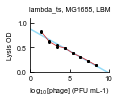

In [139]:
def plot_piecesie_linear(x_test, x_arr,y_arr):
    x_list = sorted(set(x_arr));
    y_list = list(); 
    for x_ in x_list:
        idx = np.where(x_arr==x_)[0];
        y_list.append(np.mean(y_arr[idx]));
    #piece_wise_linear
    x_list = np.array(x_list);
    y_list = np.array(y_list);
    
    idx_test = np.where(x_list>x_test)[0][0];
    x1 = x_list[idx_test-1];
    x2 = x_list[idx_test];
    y1 = y_list[idx_test-1];
    y2 = y_list[idx_test];
    
    y_test = (x_test - x1)/(x2 - x1)*(y2 - y1) + y1; 
    return y_test
#plot_piecesie_linear = np.vectorize(plot_piecesie_linear); 

fontSize=7
matplotlib.rcParams.update({"axes.formatter.limits": (-4,4),'font.family':'Arial','font.size': fontSize, "axes.titlesize": fontSize, "xtick.labelsize": fontSize, "ytick.labelsize": fontSize,})
plotStyles={"markersize":12,"markeredgewidth":2.0,"linewidth":2.0}
stepStyles={"markersize":15,"markeredgewidth":3.0,"linewidth":4.0,"where":"post"}
scatterStyles={"linewidth":1.0}
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams.update({"figure.figsize": (1.4,1.0),'font.size':7})

ax = plt.subplot(1,1,1)
x_plt = np.linspace(np.min(x_dataAll), np.max(x_dataAll), 102)[1:-1];
y_plt = np.zeros(100);
for i in range(100):
    y_plt[i] = plot_piecesie_linear(x_plt[i], x_dataAll, y_dataAll); 
#y_plt = plot_piecesie_linear(x_plt, x_dataAll, y_dataAll); 
plt.plot(x_dataAll, y_dataAll, 'o', markersize=2,color='k',zorder=10)
plt.plot(xdata, linear(xdata, k_arr_mean, b_arr_mean),color='#96DCF8',zorder=0)
plt.plot(x_plt, y_plt, linewidth=0.75, color='tab:red',zorder=5)
#plt.legend()
plt.xlabel('$\log_{10}$[phage] (PFU mL-1)')
plt.ylabel('Lysis OD')
plt.ylim((0,1.1))
plt.yticks([0,0.5,1])
plt.xlim((0,10))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis="y",direction="in")
ax.tick_params(axis="x",direction="in")
plt.title('lambda_ts, MG1655, LBM',fontsize=7)
plt.savefig('../output/Sfig4a-lambda-ts.pdf', format='pdf', bbox_inches='tight')

Text(0.5, 1.0, 'Calibration curve for $\\lambda_{ts}$ at 38 C')

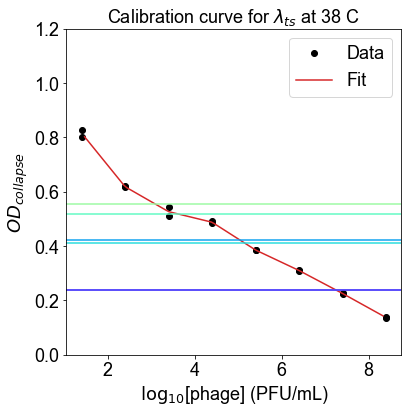

In [140]:
fontSize=18
matplotlib.rcParams.update({"axes.formatter.limits": (-4,4),'font.family':'Arial','font.size': fontSize, "axes.titlesize": fontSize, "xtick.labelsize": fontSize, "ytick.labelsize": fontSize,})
matplotlib.rcParams.update({"figure.figsize": (6,6)})

x_plt = np.linspace(np.min(x_dataAll), np.max(x_dataAll), 102)[1:-1];
y_plt = np.zeros(100);
for i in range(100):
    y_plt[i] = plot_piecesie_linear(x_plt[i], x_dataAll, y_dataAll); 
#y_plt = plot_piecesie_linear(x_plt, x_dataAll, y_dataAll); 
plt.plot(x_dataAll, y_dataAll, 'o', color='k',label='Data')
plt.plot(x_plt, y_plt, color='tab:red',label='Fit')

n = 0; 
t_thesh = 150; 
for idj in ['C1','C2','C3','C4','C5','C6']:
    lysisOD = get_lysisOD(df, idj, ymean_LB, t_thesh); 
    plt.axhline(y=lysisOD,color=colors[n])
    n = n+1;
plt.legend()
plt.xlabel('$\log_{10}$[phage] (PFU/mL)')
plt.ylabel('$OD_{collapse}$')
plt.ylim((0,1.2))
#plt.grid(True)
plt.title('Calibration curve for $\lambda_{ts}$ at 38 C',fontsize=18)

In [141]:
samples_group = {'A':['C1','C2'],
                'B':['C3','C4'],
                'C':['C5','C6']}

bar_ygPiece = np.zeros(3);
bar_yg_errPiece = np.zeros(3);

n = 0; 
for sample in list(samples_group.keys()):
    id1 = samples_group[sample][0];
    id2 = samples_group[sample][1];
    
    lysisOD1 = lysisODlist[id1]; 
    lysisOD2 = lysisODlist[id2]; 
    log10conc = np.zeros(2);
    
    log10conc[0] = piecesie_linear(lysisOD1, x_dataAll, y_dataAll)
    log10conc[1] = piecesie_linear(lysisOD2, x_dataAll, y_dataAll)
    #print((lysisOD1, lysisOD2))
    #print(log10conc)
    #print('====')
    bar_ygPiece[n] = np.mean(np.power(10, log10conc)); 
    bar_yg_errPiece[n] = np.std(np.power(10, log10conc))/np.sqrt(2); 
    n = n+1;

In [142]:
np.save('../tmp/interpolation/ts.npy', bar_ygPiece)
np.save('../tmp/interpolation/ts_err.npy', bar_yg_errPiece)

In [143]:
bar_a= np.zeros(3);
bar_b = np.zeros(3);

n = 0; 
for sample in list(samples_group.keys()):
    id1 = samples_group[sample][0];
    id2 = samples_group[sample][1];
    
    lysisOD1 = lysisODlist[id1]; 
    lysisOD2 = lysisODlist[id2]; 
    log10conc = np.zeros(2);
    
    log10conc[0] = piecesie_linear(lysisOD1, x_dataAll, y_dataAll)
    log10conc[1] = piecesie_linear(lysisOD2, x_dataAll, y_dataAll)
    #print((lysisOD1, lysisOD2))
    #print(log10conc)
    #print('====')
    bar_a[n] = np.power(10, log10conc[0]); 
    bar_b[n] = np.power(10, log10conc[1]); 
    n = n+1;
    
np.save('../tmp/interpolation/tsa.npy', bar_a)
np.save('../tmp/interpolation/tsb.npy', bar_b)